In [8]:
from stompy.model.fish_ptm import ptm_tools
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
from stompy import utils
from stompy.spatial import wkb2shp
from matplotlib import cm
import numpy as np
import xarray as xr
import re

from matplotlib.colors import LogNorm
from stompy.model.suntans import sun_driver
%matplotlib notebook

In [10]:
small=1e-4

def map_bilog(x):
    return np.sign(x)*np.log10(np.abs(x).clip(small,np.inf)/small)
def unmap_bilog(y):
    return np.sign(y)*small*10**np.abs(y)

from matplotlib.ticker import ScalarFormatter
sf=ScalarFormatter()
sf._usetex=True
def mapped_label(y):
    if y==0.0:
        #s="\pm " + sf.format_data(small)
        #s="0"
        s="passive"
    else:
        s=sf.format_data(unmap_bilog(y))
    s="$"+s+"$"
    if y>0:
        s=" "+s
    return s


In [11]:
run_set=dict(ptm_bin_files=glob.glob('all_sources/ebmud_all_w/*_bin.out'),
             name='ebda_all_w')

# Newer run, with fewer classes, but longer time, and includes
# napa.
#run_set=dict(ptm_bin_files=glob.glob('all_sources/ebda_most_w_dec/src000_*_bin.out'),
#             name='ebda_most_w')

#run_set=dict(ptm_bin_files=glob.glob('all_sources/ebda_most_w_dec/NAPA_*_bin.out'),
#             name='napa_most_w')


In [12]:
ptm_bin_files=run_set['ptm_bin_files']

# Get settling velocities just from the filename
ptm_bin_w_s=[]
for fn in ptm_bin_files:
    fn=os.path.basename(fn)
    g=re.match(".*(down|up|none)([0-9]*)_bin.out",fn)
    if g.group(1)=='none':
        w_s=0.0
    else:
        w_s=float(g.group(2))/1e6
        if g.group(1)=='up': w_s*=-1
    ptm_bin_w_s.append(w_s)
    
order=np.argsort(-np.array(ptm_bin_w_s))

ptm_bin_w_s=[ptm_bin_w_s[i] for i in order]
ptm_bin_files=[ptm_bin_files[i] for i in order]


In [13]:
ptm_bins=[ptm_tools.PtmBin(bf) for bf in ptm_bin_files]

In [14]:
last_timesteps=[b.count_timesteps() for b in ptm_bins]
tstep=min(last_timesteps)-1
tstep

1460

In [15]:
t0,_=ptm_bins[0].read_timestep(0)
tN,_=ptm_bins[0].read_timestep(tstep)
print(f"Start: {t0}  End: {tN}  Duration: {tN-t0}")

Start: 2017-06-01 01:00:00  End: 2017-07-01 11:00:00  Duration: 30 days, 10:00:00


In [17]:
ls /opt2/sfb_ocean/suntans/runs/

merge_015-201706/     merged_018_20170928/  merged_018_20180625/
merge_015-201707/     merged_018_20171008/  merged_018_20180705/
merge_015-201708/     merged_018_20171018/  merged_018_20180715/
merge_015-201709/     merged_018_20171028/  merged_019_20170610/
merge_015-201710/     merged_018_20171107/  merged_019_20170720/
merge_015-201711/     merged_018_20171117/  merged_020_20170610/
merge_016-201706/     merged_018_20171127/  merged_020_20170620/
merge_016-201707/     merged_018_20171207/  merged_020_20170630/
merge_016-201708/     merged_018_20171217/  merged_020_20170710/
merge_016-201709/     merged_018_20171227/  merged_020_20170720/
merge_016-201710/     merged_018_20180106/  merged_020_20170730/
merge_016-201711/     merged_018_20180116/  merged_020_20170809/
merge_016-201712/     merged_018_20180126/  merged_020_20170819/
merge_016-201801/     merged_018_20180205/  merged_020_20170829/
merge_016-201802/     merged_018_20180215/  merged_020_20170908/
merge_017-201706/     mer

In [20]:
# This run got deleted (passive voice)
#model=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_009-20171201/")
model=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merged_020_20170610/")
grid=model.grid

In [37]:
bc_ds=model.load_bc_ds()
src_xy=grid.cells_centroid()[bc_ds.point_cell.values[0]]

<IPython.core.display.Javascript object>


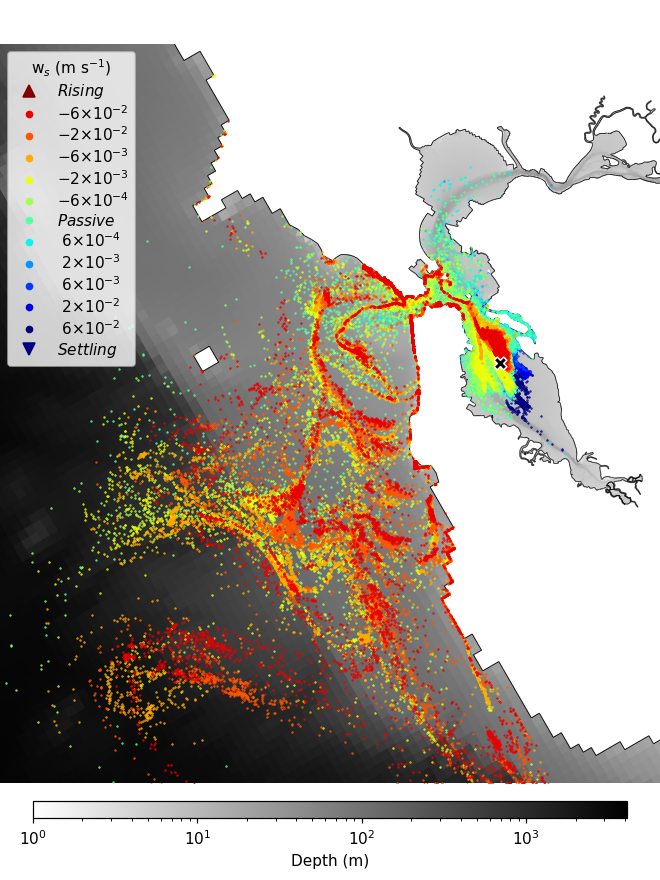

In [48]:
fig=plt.figure(figsize=(6,8))
ax=fig.add_subplot(1,1,1)
zoom=(475100., 575922., 4081601., 4240793.)

ccoll=grid.plot_cells(values=-grid.cells['depth'].clip(-np.inf,-1),
                      cmap=cm.gray_r,
                      lw=0.8,
                      norm=LogNorm())
ccoll.set_edgecolor('face')

cmap=cm.jet

ax.plot([np.nan],[np.nan],color=cmap(0.0),ms=1,marker='v',label='$Settling$',lw=0)

for i,pb in enumerate(ptm_bins):
    col=cmap(float(i)/len(ptm_bins))
    t,parts=pb.read_timestep(tstep)
    label=mapped_label(map_bilog(ptm_bin_w_s[i]))
    if ptm_bin_w_s[i]==0.0:
        label='$Passive$'
    ax.plot(parts['x'][:,0],parts['x'][:,1],'.',color=col,ms=1,
            label=label)

ax.plot([np.nan],[np.nan],color=cmap(1.0),ms=1,marker='^',lw=0,label='$Rising$')

scat=plt.scatter([src_xy[0]],[src_xy[1]],70,color='k',zorder=10,marker='X',
                 edgecolor='w')
    
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
cax=fig.add_axes([0.05,0.07,0.9,0.02])
plt.colorbar(ccoll,cax=cax,label='Depth (m)',orientation='horizontal')
# Flip to feel like depth
cax_zoom=cax.axis()
cax.axis(ymin=cax_zoom[3],ymax=cax_zoom[2])

plt.setp( ax.spines.values(), visible=0)
grid.plot_boundary(color='k',lw=0.5,ax=ax)

# tweaking the zoom
ax.set_aspect('equal',adjustable='datalim')
ax.axis(zoom)
fig.subplots_adjust(left=0.00,top=0.95,bottom=0.11,right=1.)
handles=ax.lines[::-1]
labels=[h.get_label() for h in handles]

#labels[0]='$Rising$'
#labels[-1]='$Settling$'

#import matplotlib.patches as mpatches
#import matplotlib.pyplot as plt
#blue_patch = mpatches.Patch(color='blue', label='$Settling$')

#handles.append(blue_patch)
#labels.append('$Settling$')

leg=ax.legend(labels=labels,handles=handles,
              loc='upper left',bbox_to_anchor=[0.0,1],
              title="w$_s$ (m s$^{-1}$)",
              markerscale=8,labelspacing=0.2)
fig.savefig('%s-end_map-v2.png'%run_set['name'],dpi=150)

In [20]:
# Define in bay vs. out of bay
regions=wkb2shp.shp2geom("../suntans/grid-merged/poly_features.shp")
ocean_poly=regions[ regions['name']=='ocean_region']['geom'][0]

from matplotlib.path import Path
ocean_path=Path(vertices=np.array(ocean_poly.exterior),closed=True)

In [33]:
# Generate a dataframe showing percent in/out of the Bay
# at the end of the run (or by time step tstep)
recs=[]

for i,pb in enumerate(ptm_bins):
    t,parts=pb.read_timestep(tstep)

    in_ocean=ocean_path.contains_points(parts['x'][:,:2])
    rec=dict(w_s=ptm_bin_w_s[i],
             nparts=len(parts['x']),
             in_ocean=in_ocean.sum(),
             in_bay=(~in_ocean).sum())
    recs.append(rec)

df=pd.DataFrame(recs)
df['% Ocean']=(100*df.in_ocean / df.nparts).round(1)
df['% Bay']  =(100*df.in_bay   / df.nparts).round(1)
df['# Particles']=df.nparts

df=df.set_index('w_s')

df_summary=df.loc[:, ['# Particles', '% Bay','% Ocean']]
df_summary.to_excel('%s-escape-summary.xlsx'%run_set['name'])

In [65]:
# Now look at how long particles have been in the system.
# each particle is given an age from release, whether
# it has exited, and its w_s.
# then we look at how exit fraction for each w_s corresponds
# to age
# process a single group at a time
def escape_dataset(pb,stride=24):
    ages=[] # list of arrays
    in_oceans=[] # lists of arrays

    # indexed by particle id.
    rel_times=np.zeros(0,'<M8[s]')

    for tstep in range(0,pb.count_timesteps(),stride):
        t,parts=pb.read_timestep(tstep)
        print(".", end='')
        t=utils.to_dt64(t)

        in_ocean=ocean_path.contains_points(parts['x'][:,:2])
        # Update particle ages for new particles.
        # only accurate to within the stride of this loop.
        N_new_parts=parts['id'].max() - len(rel_times)
        new_rel_times=np.ones(N_new_parts,rel_times.dtype)
        new_rel_times[:]=t
        rel_times=utils.array_concatenate([rel_times,new_rel_times])

        ages.append( (t-rel_times[parts['id']-1])/np.timedelta64(1,'s') / 86400. )
        in_oceans.append(in_ocean)
    print()
    
    # put this into a DataFrame just to get the nice grouping code
    df_exit=pd.DataFrame()
    df_exit['age']=np.concatenate(ages)
    df_exit['in_ocean']=np.concatenate(in_oceans)
    # convert to a summary of count in_ocean by age
    exit_summary=(df_exit.groupby(['age','in_ocean']).size()
                   .unstack(fill_value=0).stack() )
    exit_summary=exit_summary.to_frame()
    exit_summary.rename({0:'count'},axis=1,inplace=True)
    # then get back to dataset land for better dimension handling
    ds=xr.Dataset.from_dataframe(exit_summary)
    ds['nparts']=ds['count'].sum(dim='in_ocean')
    if True not in ds['in_ocean']:
        # in some cases no particles from a group ever make it out.
        ds['ocean_pct']=ds.nparts.dims,0*ds.nparts
    else:
        ds['ocean_pct']=100. * ds['count'].sel(in_ocean=True) / ds['nparts']
    return ds

In [66]:
escape_datasets=[escape_dataset(pb) for pb in ptm_bins]

.............................................................
.............................................................
.............................................................
.............................................................
.............................................................
.............................................................
.............................................................
.............................................................
.............................................................
.............................................................
.............................................................


<IPython.core.display.Javascript object>


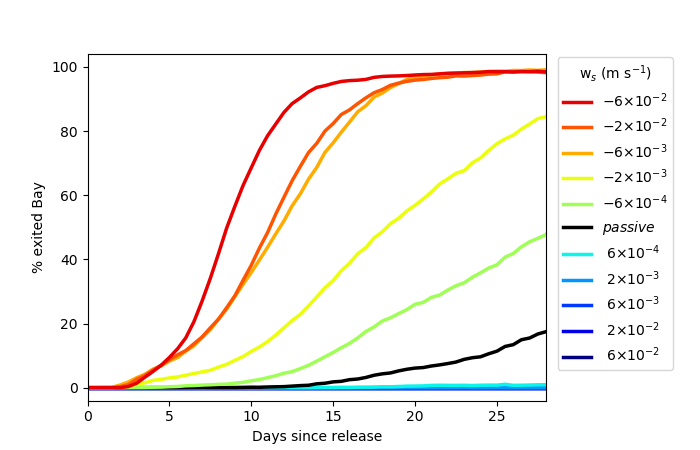

In [78]:
fig=plt.figure(figsize=(7,4.5))
ax=fig.add_subplot(1,1,1)
for i,(w_s,ds) in enumerate(zip(ptm_bin_w_s,escape_datasets)):
    col=cm.jet(float(i)/len(ptm_bin_w_s))
    lbl=mapped_label(map_bilog(w_s))
    lw=2.5
    
    if w_s==0.0:
        col='k'
    ax.plot(ds.age,ds.ocean_pct,color=col,lw=lw,label=lbl)
        
    
ax.legend(handles=ax.lines[::-1],title="w$_s$ (m s$^{-1}$)",
         loc='upper left',bbox_to_anchor=[1.01,1.01])
ax.set_ylabel("% exited Bay")
ax.set_xlabel("Days since release")
fig.subplots_adjust(right=0.78)
ax.axis(xmin=0,xmax=28,ymin=-4,ymax=104)
fig.savefig("escape_time_%s.png"%run_set['name'],dpi=150)


(0, 28, -4, 104)

<IPython.core.display.Javascript object>


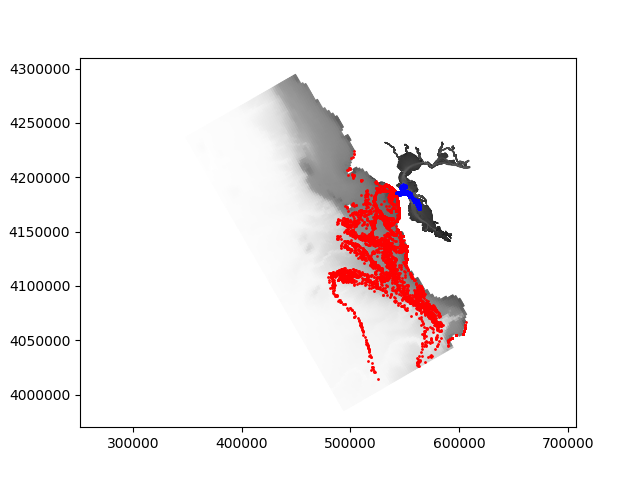

In [186]:
pb=ptm_bins[-1] # for i,pb in enumerate(ptm_bins):
t,parts=pb.read_timestep(tstep)

in_ocean=ocean_path.contains_points(parts['x'][:,:2])

fig=plt.figure()
ax=fig.add_subplot(1,1,1)

ccoll=grid.plot_cells(values=-grid.cells['depth'].clip(-np.inf,-1),
                      cmap=cm.gray,
                      lw=0.8,
                      norm=LogNorm())
ccoll.set_edgecolor('face')

ax.plot(parts['x'][in_ocean,0],parts['x'][in_ocean,1],'.',color='r',ms=2)
ax.plot(parts['x'][~in_ocean,0],parts['x'][~in_ocean,1],'.',color='b',ms=2)
